# Third CatLearn tutorial.

This tutorial is intended to give further intuition for the Gaussian process and compare it to a linear model.

Like in tutorial 1, we set up a known underlying function, generate training
and test data and calculate predictions and errors. We will compare the results
of linear ridge regression, Gaussian linear kernel regression and finally a
Gaussian process with the usual squared exponential kernel.

In [39]:
# Import packages.
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

from catlearn.preprocess.scaling import standardize, target_standardize
from catlearn.regression import GaussianProcess, RidgeRegression
from catlearn.regression.cost_function import get_error

In [40]:
# A known underlying function in two dimensions
def afunc(x):
    """2D linear function (plane)."""
    return 3. * x[:, 0] - 1. * x[:, 1] + 500.

In [41]:
# Setting up data.
# A number of training points in x.
train_points = 17
# Magnitude of the noise.
noise_magnitude = 1.0

# Randomly generate the training datapoints x.
train_d1 = 2 * (np.random.random_sample(train_points) - 0.5)
train_d2 = 2 * (np.random.random_sample(train_points) - 0.5)
train_x1, train_x2 = np.meshgrid(train_d1, train_d2)
train = np.hstack([np.vstack(train_d1), np.vstack(train_d2)])

# Each element in the list train can be referred to as a fingerprint.
# Call the underlying function to produce the target values.
target = np.array(afunc(train))

# Add random noise from a normal distribution to the target values.
for i in range(train_points):
    target[i] += noise_magnitude * np.random.normal()

# Generate test datapoints x.
test_points = 16
test1d = np.vstack(np.linspace(-1.3, 1.3, test_points))
test_x1, test_x2 = np.meshgrid(test1d, test1d)
test = np.hstack([np.vstack(test_x1.ravel()), np.vstack(test_x2.ravel())])

print(np.shape(train))
print(np.shape(test))
print(np.shape(target))

# Standardize the training and test data on the same scale.
std = standardize(train_matrix=train,
                  test_matrix=test)

# Standardize the training targets.
train_targets = target_standardize(target)
# Note that predictions will now be made on the standardized scale.

(9, 2)
(900, 2)
(9,)


## Model example 1 - Ridge regression.

Ridge regression prediction: 0.12099077222


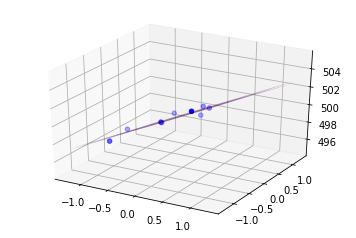

In [42]:
# Test ridge regression predictions.
rr = RidgeRegression()
reg = rr.find_optimal_regularization(X=std['train'],
                                     Y=train_targets['target'])
coef = rr.RR(X=std['train'], Y=train_targets['target'], omega2=reg)[0]
# Test the model.
sumd = 0.
rr_predictions = []
for tf, tt in zip(std['test'], afunc(test)):
    p = ((np.dot(coef, tf)) * train_targets['std']) + train_targets['mean']
    rr_predictions.append(p)
    sumd += (p - tt) ** 2
print('Ridge regression prediction:', (sumd / len(test)) ** 0.5)
# Plotting.
plt3d = plt.figure().gca(projection='3d')
# Plot training data.
plt3d.scatter(train[:, 0], train[:, 1], target,  color='b')
# Plot exact function.
plt3d.plot_surface(test_x1, test_x2,
                   afunc(test).reshape(np.shape(test_x1)),
                   alpha=0.3, color='b')
# Plot the prediction.
plt3d.plot_surface(test_x1, test_x2,
                   np.array(rr_predictions).reshape(np.shape(test_x1)),
                   alpha=0.3, color='r')

## Model example 2 - Gausian linear kernel regression.

Gaussian linear regression prediction: 0.117940314214


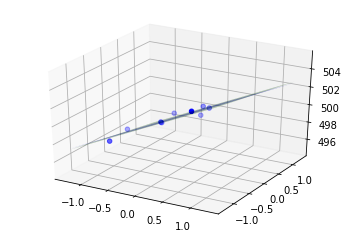

In [43]:
# Define prediction parameters
kdict = {'k1': {'type': 'linear', 'scaling': 0.9},
         'c1': {'type': 'constant', 'const': 0.0}}
# Starting guess for the noise parameter
sdt1 = noise_magnitude
# Set up the gaussian process.
gp1 = GaussianProcess(kernel_dict=kdict, regularization=sdt1,
                      train_fp=std['train'],
                      train_target=train_targets['target'],
                      optimize_hyperparameters=True,
                      scale_optimizer=False)
# Do predictions.
linear = gp1.predict(test_fp=std['test'], get_validation_error=True,
                     test_target=afunc(test))
prediction = np.array(linear['prediction']) * train_targets['std'] + \
    train_targets['mean']
error = get_error(prediction, afunc(test))
print('Gaussian linear regression prediction:', error['absolute_average'])
# Plotting.
plt3d = plt.figure().gca(projection='3d')
# Plot training data.
plt3d.scatter(train[:, 0], train[:, 1], target,  color='b')
# Plot exact function.
plt3d.plot_surface(test_x1, test_x2,
                   afunc(test).reshape(np.shape(test_x1)),
                   alpha=0.3, color='b')
# Plot the prediction.
plt3d.plot_surface(test_x1, test_x2,
                   prediction.reshape(np.shape(test_x1)),
                   alpha=0.3, color='g')

## Model example 3 - Gaussian Process with squared exponential kernel.

This kernel is also known as the Gaussian kernel, which is a bit confusing and not related to the term Gaussian process.

Gaussian process prediction: 0.367185486052


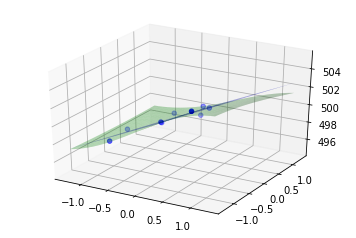

In [44]:
# Set up the prediction routine and optimize hyperparameters.
kdict = {'k1': {'type': 'gaussian', 'width': [0.3, 3.], 'scaling': 0.9}}
# Starting guess for the noise parameter
sdt1 = noise_magnitude
# Set up the gaussian process.
gp2 = GaussianProcess(kernel_dict=kdict, regularization=sdt1,
                      train_fp=std['train'],
                      train_target=train_targets['target'],
                      optimize_hyperparameters=True,
                      scale_optimizer=False)
# Do the optimized predictions.
gaussian = gp2.predict(test_fp=std['test'])
# Put predictions back on real scale.
prediction = np.array(gaussian['prediction']) * train_targets['std'] + \
    train_targets['mean']
# Get average errors.
error = get_error(prediction, afunc(test))
print('Gaussian process prediction:', error['absolute_average'])
# Plotting.
plt3d = plt.figure().gca(projection='3d')
# Plot training data.
plt3d.scatter(train[:, 0], train[:, 1], target,  color='b')
# Plot exact function.
plt3d.plot_surface(test_x1, test_x2,
                   afunc(test).reshape(np.shape(test_x1)),
                   alpha=0.3, color='b')
# Plot the prediction.
plt3d.plot_surface(test_x1, test_x2,
                   prediction.reshape(np.shape(test_x1)),
                   alpha=0.3, color='g')

## Experiment and get intuition.

Try playing around with the training set size (density) and noise_magnitude and rerun the models.